# Appendix 

In [3]:
import pandas as pd
import numpy as np
import pickle 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

In [4]:
#Read in dataset
df = pd.read_csv('../Data for Verisk Climate Data Science Candidate Exercise May 2015.csv')
df.head(5)

,merchantstate,transdate,TransactionIndex,PRCP,SNWD,TMAX,TMIN
0,TX,1/1/13,0.402095,0.045276,0,56.03,40.01
1,TX,1/2/13,0.465669,0.000000,0,42.44,34.61
2,TX,1/3/13,0.472393,0.000000,0,51.53,32.54
3,TX,1/4/13,0.489343,0.005906,0,50.54,41.00
4,TX,1/5/13,0.528285,0.389764,0,49.46,39.02


## Transform Data 

### Data Transformation
- Converting date to weekday/weekend
- Averaging the low/high temperature due to correlation


In [5]:
#Converting date 
df['transdate_datetime']=pd.to_datetime(df['transdate'])
#Monday=0, Sunday=6
df['transdate_dayofweek']=df['transdate_datetime'].dt.dayofweek
#Coding Weekend
df['weekend']=0
df.loc[df['transdate_dayofweek'] >4, 'weekend'] = 1
df['weekofyear']=df['transdate_datetime'].dt.weekofyear
#Averaging temperture
df['AVGTEMP']=(df.TMAX+df.TMIN)/2
#Raining or not
df['PRCP_YN']=0
df.loc[df['PRCP']>0.0,'PRCP_YN']=1
#Quantile for Rain when >0
df['PRCP_Q']=pd.qcut(df.loc[df.PRCP>0,'PRCP'],q=4,labels=['1stQ','2ndQ','3rdQ','4thQ'])
df['PRCP_Q'] = df['PRCP_Q'].cat.add_categories(['None'])
df['PRCP_Q'].fillna('None',inplace=True)
#Precipitation in the next two days
df['PRCP_Next2days']=0
for index, row in df.head(728).iterrows():
    if df.ix[index+1:index+2,'PRCP'].sum()>0:
        df.ix[index,'PRCP_Next2days']=1    
df['PRCP_Next1days']=0
for index, row in df.head(728).iterrows():
    if df.ix[index+1,'PRCP']>0:
        df.ix[index,'PRCP_Next1days']=1

#Normalize data for OLS
df_ols=pd.DataFrame.copy(df)
df_ols['PRCP_N']=df_ols['PRCP']-df_ols['PRCP'].mean()
df_ols['AVGTEMP_N']=df_ols['AVGTEMP']-df_ols['AVGTEMP'].mean()

#Change to categorical
df['transdate_dayofweek_C'] = df['transdate_dayofweek'].astype('category')
df['weekend_C'] = df['weekend'].astype('category')
df['PRCP_YN'] = df['PRCP_YN'].astype('category')
df['PRCP_Next1days'] = df['PRCP_Next1days'].astype('category')
df['PRCP_Next2days'] = df['PRCP_Next2days'].astype('category')


## Create Data Subset

In [6]:
# Transaction Volume >0.8 and <0.25 were removed to compensate for holidays
df1=df[(df.TransactionIndex<.8) & (df.TransactionIndex>.25)].sort_index()
# df1_ols=df_ols[(df_ols.TransactionIndex<.8) & (df_ols.TransactionIndex>.25)].sort_index()
df[(df.TransactionIndex<.8) & (df.TransactionIndex>.25)].describe()

,TransactionIndex,PRCP,SNWD,TMAX,TMIN,transdate_dayofweek,weekend,weekofyear,AVGTEMP
count,717.000000,717.000000,717,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,0.533953,0.093577,0,78.568159,57.451297,3.005579,0.285914,26.209205,68.009728
std,0.073940,0.253496,0,15.400788,15.418247,2.003481,0.452164,14.895475,15.075393
min,0.256514,0.000000,0,31.100000,19.670000,0.000000,0.000000,1.000000,26.870000
25%,0.482983,0.000000,0,68.450000,43.970000,1.000000,0.000000,13.000000,55.760000
50%,0.513521,0.000000,0,80.510000,59.000000,3.000000,0.000000,26.000000,69.980000
75%,0.583544,0.039370,0,91.490000,72.500000,5.000000,1.000000,39.000000,81.725000
max,0.790021,2.141732,0,103.550000,79.970000,6.000000,1.000000,52.000000,91.760000


### Top transaction days for each year

In [7]:
df[df.transdate_datetime.dt.year==2013].sort_values(['TransactionIndex'],ascending=False).head(10)
df[df.transdate_datetime.dt.year==2014].sort_values(['TransactionIndex'],ascending=False).head(10)

,merchantstate,transdate,TransactionIndex,PRCP,SNWD,TMAX,TMIN,transdate_datetime,transdate_dayofweek,weekend,weekofyear,AVGTEMP,PRCP_YN,PRCP_Q,PRCP_Next2days,PRCP_Next1days,transdate_dayofweek_C,weekend_C
694,TX,11/26/14,1.000000,0.000000,0,69.98,45.50,2014-11-26,2,0,48,57.740,0,None,0,0,2,0
722,TX,12/24/14,0.968919,0.000000,0,53.51,36.50,2014-12-24,2,0,52,45.005,0,None,1,0,2,0
721,TX,12/23/14,0.932751,0.269685,0,57.56,45.05,2014-12-23,1,0,52,51.305,1,3rdQ,0,0,1,0
453,TX,3/30/14,0.901306,0.000000,0,76.01,46.49,2014-03-30,6,1,13,61.250,0,None,0,0,6,1
729,TX,12/31/14,0.877421,0.000000,0,42.44,36.50,2014-12-31,2,0,1,39.470,0,None,0,0,2,0
452,TX,3/29/14,0.838454,0.000000,0,76.46,48.47,2014-03-29,5,1,13,62.465,0,None,0,0,5,1
693,TX,11/25/14,0.831097,0.000000,0,65.48,36.95,2014-11-25,1,0,48,51.215,0,None,0,0,1,0
494,TX,5/10/14,0.800541,0.000000,0,87.53,63.50,2014-05-10,5,1,19,75.515,0,None,1,0,5,1
720,TX,12/22/14,0.777475,0.000000,0,69.53,51.98,2014-12-22,0,0,52,60.755,0,None,1,1,0,0
495,TX,5/11/14,0.756326,0.000000,0,87.53,74.03,2014-05-11,6,1,19,80.780,0,None,1,1,6,1


### Correlation of AVGTEMP

In [8]:
df[['AVGTEMP','TMAX','TMIN']].corr()

,AVGTEMP,TMAX,TMIN
AVGTEMP,1.000000,0.978492,0.978535
TMAX,0.978492,1.000000,0.914977
TMIN,0.978535,0.914977,1.000000


In [9]:
print 'Number of days with PRCP=0: %s' %(df[df['PRCP']>0].shape[0])
print 'Percent of days with PRCP=0: %s' %(df[df['PRCP']>0].shape[0]/float(df.shape[0]))

Number of days with PRCP=0: 272
Percent of days with PRCP=0: 0.372602739726


### Metrics by Week

In [10]:
g=df.groupby('weekofyear')['AVGTEMP','PRCP','TransactionIndex'].mean()
print g.sort_values('TransactionIndex',ascending=False).head(10).index.values

[48 47 51 19 13 50 44 52 49  1]


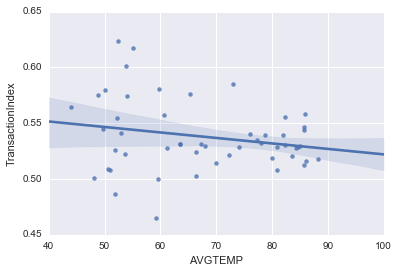

In [11]:
sns.regplot(x="AVGTEMP", y="TransactionIndex", data=g, fit_reg=True)

### Machine Learning Data Prep

In [12]:
df1_ml=pd.get_dummies(df1[['AVGTEMP','PRCP','weekend_C','transdate_dayofweek_C','TransactionIndex']])
df_ml=pd.get_dummies(df[['AVGTEMP','PRCP','weekend_C','transdate_dayofweek_C','TransactionIndex']])
df1_ml.head(5)

,AVGTEMP,PRCP,TransactionIndex,weekend_C_0,weekend_C_1,transdate_dayofweek_C_0,transdate_dayofweek_C_1,transdate_dayofweek_C_2,transdate_dayofweek_C_3,transdate_dayofweek_C_4,transdate_dayofweek_C_5,transdate_dayofweek_C_6
0,48.020,0.045276,0.402095,1,0,0,1,0,0,0,0,0
1,38.525,0.000000,0.465669,1,0,0,0,1,0,0,0,0
2,42.035,0.000000,0.472393,1,0,0,0,0,1,0,0,0
3,45.770,0.005906,0.489343,1,0,0,0,0,0,1,0,0
4,44.240,0.389764,0.528285,0,1,0,0,0,0,0,1,0


In [13]:
#Pickle DataFrames
f=open( "../database/df1.pkl", "wb" )
pickle.dump( df1,f)
f.close()

f=open( "../database/df.pkl", "wb" )
pickle.dump( df,f)
f.close()

f=open( "../database/df_ml.pkl", "wb" )
pickle.dump(df_ml,f)
f.close()

f=open( "../database/df1_ml.pkl", "wb" )
pickle.dump( df1_ml,f)
f.close()

In [14]:
# features=['PRCP','AVGTEMP','weekend'] #,'PRCP_YN','PRCP_YN','PRCP_Q'
# features=['PRCP','weekend']
# features=['PRCP_YN','weekend']
# features=['PRCP_YN','transdate_dayofweek']
# features=['PRCP','transdate_dayofweek']
# features=['PRCP','transdate_dayofweek']
# features=['weekend_0','weekend_1','AVGTEMP','PRCP_YN_0','PRCP_YN_1']
features=['AVGTEMP','PRCP','transdate_dayofweek_C_0','transdate_dayofweek_C_1','transdate_dayofweek_C_2',\
         'transdate_dayofweek_C_3','transdate_dayofweek_C_4','transdate_dayofweek_C_5','transdate_dayofweek_C_6']
# features=['AVGTEMP','PRCP','weekend_0','weekend_1']
response=['TransactionIndex']

X=df_ml[features]
y=df_ml[response]

## Testing Hypothesis of Significance of the day of the week

Ho: Transaction index are equal during every day of the week <br>
Ha: Transaction index are NOT equal during every day of the week <br>

In [15]:
# model1=smf.ols(formula='TransactionIndex ~ C(weekend) + AVGTEMP + PRCP',data=df1)
model1=smf.ols(formula='TransactionIndex ~ C(transdate_dayofweek) + AVGTEMP + PRCP',data=df1)
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:       TransactionIndex   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     63.65
Date:                Mon, 01 Feb 2016   Prob (F-statistic):           2.74e-78
Time:                        15:38:14   Log-Likelihood:                 1044.8
No. Observations:                 717   AIC:                            -2072.
Df Residuals:                     708   BIC:                            -2030.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

In [16]:
mc1=multi.MultiComparison(df1['TransactionIndex'],df1['transdate_dayofweek'])
res1=mc1.tukeyhsd()
print (res1.summary())
#Monday is signficantly different than other days except for Friday
#Tuesday is signficantly different than the weekend
#Wednesday is signficantly different than the Fri+weekend
#Thursday is signficantly different than the weekend
#Friday is signficantly different than the weekend
#Satruday is NOT signficantly different than Sunday

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.0381  -0.0615 -0.0146  True 
  0      2     -0.05   -0.0735 -0.0265  True 
  0      3    -0.0404  -0.0637  -0.017  True 
  0      4    -0.0213  -0.0446  0.002  False 
  0      5     0.0613   0.0379  0.0847  True 
  0      6     0.0788   0.0555  0.1022  True 
  1      2    -0.0119  -0.0355  0.0116 False 
  1      3    -0.0023  -0.0257  0.0211 False 
  1      4     0.0168  -0.0066  0.0401 False 
  1      5     0.0994   0.0759  0.1228  True 
  1      6     0.1169   0.0935  0.1403  True 
  2      3     0.0096  -0.0139  0.0331 False 
  2      4     0.0287   0.0053  0.0522  True 
  2      5     0.1113   0.0877  0.1349  True 
  2      6     0.1288   0.1053  0.1523  True 
  3      4     0.0191  -0.0042  0.0424 False 
  3      5     0.1017   0.0783  0.1251  True 
  3      6     0.1192   0.0959  0.1426  True 
  4      5     0.0826   0.059

In [17]:
# Fit regression tree
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=30, random_state=4)
randForest = RandomForestRegressor(n_estimators=10,max_depth=2,random_state=4)

scores = cross_val_score(regr_1, X, np.ravel(y), cv=10, scoring='mean_squared_error')
print 'Decision Tree Avg RMSE is:%s' %(np.sqrt(-scores).mean())

scores = cross_val_score(regr_2, X, np.ravel(y), cv=10, scoring='mean_squared_error')
print 'AdaBoost Decision Tree Avg RMSE is:%s' %(np.sqrt(-scores).mean())

scores = cross_val_score(randForest, X, np.ravel(y), cv=10, scoring='mean_squared_error')
print 'RandomForest Avg RMSE is:%s' %(np.sqrt(-scores).mean())

Decision Tree Avg RMSE is:0.0686909470326
AdaBoost Decision Tree Avg RMSE is:0.0866587923649
RandomForest Avg RMSE is:0.0683470932966


In [18]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,y)
print lm.score(X,y)
print lm.coef_
print lm.intercept_

0.278433754085
[[ -3.71740251e-04  -1.05127472e-02   8.89610675e-05  -2.96058598e-02
   -4.04025817e-02  -4.74906915e-02  -2.40953756e-02   6.28670844e-02
    7.86384633e-02]]
[ 0.5642008]


In [19]:
df1_ml.dtypes

AVGTEMP                    float64
PRCP                       float64
TransactionIndex           float64
weekend_C_0                float64
weekend_C_1                float64
transdate_dayofweek_C_0    float64
transdate_dayofweek_C_1    float64
transdate_dayofweek_C_2    float64
transdate_dayofweek_C_3    float64
transdate_dayofweek_C_4    float64
transdate_dayofweek_C_5    float64
transdate_dayofweek_C_6    float64
dtype: object

## Scenario1: Removing the highest 10 week transactions

In [20]:
test=df1[~ df1.weekofyear.isin(g.sort_values('TransactionIndex',ascending=False).head(10).index.values.tolist())]

test_ml=pd.get_dummies(test[['AVGTEMP','PRCP','weekend_C','transdate_dayofweek_C','TransactionIndex']])

test.describe()

,TransactionIndex,PRCP,SNWD,TMAX,TMIN,transdate_dayofweek,weekend,weekofyear,AVGTEMP
count,588.000000,588.000000,588,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000
mean,0.526004,0.091696,0,81.366531,59.953878,3.000000,0.285714,23.904762,70.660204
std,0.067818,0.242467,0,14.495608,15.006432,2.001703,0.452139,12.961131,14.441476
min,0.256514,0.000000,0,31.100000,19.670000,0.000000,0.000000,2.000000,26.870000
25%,0.480110,0.000000,0,71.510000,48.020000,1.000000,0.000000,12.000000,59.990000
50%,0.505225,0.000000,0,84.470000,64.490000,3.000000,0.000000,24.500000,74.142500
75%,0.577002,0.039370,0,92.952500,73.490000,5.000000,1.000000,35.000000,82.985000
max,0.778798,2.019685,0,103.550000,79.970000,6.000000,1.000000,46.000000,91.760000


In [21]:
features=['AVGTEMP','PRCP','transdate_dayofweek_C_0','transdate_dayofweek_C_1','transdate_dayofweek_C_2',\
         'transdate_dayofweek_C_3','transdate_dayofweek_C_4','transdate_dayofweek_C_5','transdate_dayofweek_C_6']
response=['TransactionIndex']

X=test_ml[features]
y=test_ml[response]

In [22]:
# Linear Regression with 10-fold cross-validation
lm = LinearRegression()
scores = cross_val_score(lm, X, np.ravel(y), cv=10, scoring='mean_squared_error')
print 'Linear Regression Avg RMSE is:%s' %(np.sqrt(-scores).mean())
scores = cross_val_score(lm, X, np.ravel(y), cv=10, scoring='mean_absolute_error')
print 'Linear Regression Avg MAE is:%s' %(-scores.mean())
scores = cross_val_score(lm, X, np.ravel(y), cv=10, scoring='r2')
print 'Linear Regression Avg R^2 is:%s' %(scores.mean())

Linear Regression Avg RMSE is:0.0425507152121
Linear Regression Avg MAE is:0.0277004353652
Linear Regression Avg R^2 is:0.570754103407


In [23]:
model1=smf.ols(formula='TransactionIndex ~ C(transdate_dayofweek) + AVGTEMP + PRCP',data=test)
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:       TransactionIndex   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     79.89
Date:                Mon, 01 Feb 2016   Prob (F-statistic):           1.85e-88
Time:                        15:38:15   Log-Likelihood:                 967.10
No. Observations:                 588   AIC:                            -1916.
Df Residuals:                     579   BIC:                            -1877.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

In [24]:

pd.set_option('display.max_rows', 500)
df.head(5)
# sns.factorplot(x='PRCP_Q',y='TransactionIndex', col="transdate_dayofweek", col_wrap=4,                   
#                data=df,kind="bar", size=4, aspect=.8,col_order=[0,1,2,3,4,5,6],
#                order=['None','1stQ','2ndQ','3rdQ','4thQ'])

# sns.factorplot(x='PRCP_Q',y='TransactionIndex',                    
#                data=df,kind="bar", size=6, aspect=.8,
#                order=['None','1stQ','2ndQ','3rdQ','4thQ'])

# df[df.PRCP_Q=='4thQ'].sort_values(['TransactionIndex'],ascending=False).head(100)


# sns.factorplot(x='weekofyear',y='TransactionIndex',                   
#                data=df1,kind="bar", size=6, aspect=1.2,ci=None)

# sns.lmplot(x="PRCP_Next1days", y="TransactionIndex",
#            data=df,scatter=True,fit_reg=False,x_jitter=0.01)

# sns.lmplot(x="PRCP_Next1days", y="TransactionIndex", col="transdate_dayofweek", 
#            data=df,col_wrap=3,scatter=True,fit_reg=False,x_jitter=0.01)

# sns.lmplot(x="AVGTEMP", y="TransactionIndex", col="weekend", 
#            data=df,col_wrap=3,scatter=True,fit_reg=False)

# plt.plot(df['AVGTEMP'])
# plt.show()

# g = sns.FacetGrid(df, col="transdate_dayofweek",col_wrap=4,col_order=[0,1,2,3,4,5,6])  
# g.map(plt.scatter, "PRCP_YN", "TransactionIndex")  

,merchantstate,transdate,TransactionIndex,PRCP,SNWD,TMAX,TMIN,transdate_datetime,transdate_dayofweek,weekend,weekofyear,AVGTEMP,PRCP_YN,PRCP_Q,PRCP_Next2days,PRCP_Next1days,transdate_dayofweek_C,weekend_C
0,TX,1/1/13,0.402095,0.045276,0,56.03,40.01,2013-01-01,1,0,1,48.020,1,2ndQ,0,0,1,0
1,TX,1/2/13,0.465669,0.000000,0,42.44,34.61,2013-01-02,2,0,1,38.525,0,None,1,0,2,0
2,TX,1/3/13,0.472393,0.000000,0,51.53,32.54,2013-01-03,3,0,1,42.035,0,None,1,1,3,0
3,TX,1/4/13,0.489343,0.005906,0,50.54,41.00,2013-01-04,4,0,1,45.770,1,1stQ,1,1,4,0
4,TX,1/5/13,0.528285,0.389764,0,49.46,39.02,2013-01-05,5,1,1,44.240,1,4thQ,0,0,5,1
